In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
# Task 1
# Training Data
train_data_jsonl = open('train.data.jsonl', 'r')
train_label = open('train.label.json', 'r')

# Dev Data
dev_data_jsonl = open('dev.data.jsonl', 'r')
dev_label = open('dev.label.json', 'r')

# Test Data
test_data_jsonl = open('test.data.jsonl', 'r')


# Task 2 Covid Data
covid_data_jsonl = open('covid.data.jsonl', 'r')

In [3]:
# Tweet ID (Key)
# USer ID
# Follower Count
# Text
# Time Posted
# Parent Tweets ID (If Any)
# Child tweets ID (If any)


# Find BERT tokenize max size
bert_token_list = []

tweet_dict = {}

train_label_json = json.load(train_label)
dev_label_json = json.load(dev_label)


# Make label 1 or 0
# 0 for non-rumour
def binary_label(label):
    if label == 'non-rumour':
        return 0
    else:
        return 1

def jsonl_to_list(jsonl, labels):
    out_list = []
    responses_list = []
    reply_list =[]
    
    for line in jsonl:
        data = json.loads(line)
        responses = 0

        for tweet_data in data:
            
            tweet_id = tweet_data['id']
            user_id = tweet_data['user']['id']
            follower_count = tweet_data['user']['followers_count']
            
            
            text = tweet_data['text']            
            time = tweet_data['created_at']
            parent = tweet_data['in_reply_to_status_id']


            tweet_dict[tweet_id] = {'user_id' : user_id,
                                   'follower_count' : follower_count,
                                   'text' : text,
                                   'time': time,
                                   'parent': parent}
            
            
            # get label and conver to 0 or 1
            
            try:
                label = binary_label(labels[str(tweet_id)])
                out_list.append([tweet_id, text, time, parent, label, follower_count, user_id])
            except KeyError:
                responses += 1
                reply_list.append([tweet_id, text, time, parent, follower_count, user_id])
                continue
                
        
        responses_list.append(responses)
    return out_list, responses_list, reply_list



# test data
def no_label_json(jsonl):
    output = []
    for line in jsonl:

        data = json.loads(line)
        
        for tweet_data in data:

            tweet_id = tweet_data['id']
            user_id = tweet_data['user']['id']
            follower_count = tweet_data['user']['followers_count']
            text = tweet_data['text']
            time = tweet_data['created_at']
            parent = tweet_data['in_reply_to_status_id']


            tweet_dict[tweet_id] = {'user_id' : user_id,
                                   'follower_count' : follower_count,
                                   'text' : text,
                                   'time': time,
                                   'parent': parent}

            output.append([tweet_id, text, time, parent, follower_count, user_id])
    return output
    
train_list, train_responses, train_reply = jsonl_to_list(train_data_jsonl, train_label_json)
dev_list, dev_responses, dev_reply = jsonl_to_list(dev_data_jsonl, dev_label_json)



test_list = no_label_json(test_data_jsonl)
covid_list = no_label_json(covid_data_jsonl)

In [4]:
# Make Dataframes

train_df = DataFrame(train_list, columns=['tweet_id', 'text', 'time', 'parent', 'label', 'follower_count', 'user_id'])
train_df['responses'] = np.asarray(train_responses)

train_reply_df = DataFrame(train_reply, columns=['tweet_id', 'text', 'time', 'parent', 'follower_count', 'user_id'])


dev_df = DataFrame(dev_list, columns=['tweet_id', 'text', 'time', 'parent', 'label', 'follower_count', 'user_id'])
dev_df['responses'] = np.asarray(dev_responses)

dev_reply_df = DataFrame(dev_reply, columns=['tweet_id', 'text', 'time', 'parent', 'follower_count', 'user_id'])

test_df = DataFrame(test_list, columns=['tweet_id', 'text', 'time', 'parent', 'follower_count', 'user_id'])

# Task 2
covid_df = DataFrame(covid_list, columns=['tweet_id', 'text', 'time', 'parent', 'follower_count', 'user_id'])

In [5]:
dev_reply_df[dev_reply_df['parent'] == 553588913747808256]['text']

0    @USATODAY :it's unfortunate that they got what...
1    @USATODAY @azcentral That sucks. Think bigger ...
2    “@USATODAY: #BREAKING Reports: 2 brothers susp...
3    @USATODAY Got to kill the ones that were order...
4                          @USATODAY two less to go...
5    “@USATODAY: #BREAKING Reports: 2 brothers susp...
6    “@USATODAY: #BREAKING Reports: 2 brothers susp...
7    “@USATODAY: #BREAKING Reports: 2 brothers susp...
8    “@USATODAY: #BREAKING Reports: 2 brothers susp...
9    @USATODAY I gave in...heard from my favorite r...
Name: text, dtype: object

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text_processed):
    out = []
    for line in text_processed:
        score = sid.polarity_scores(line)
        out.append(score['compound'])
    return out

def get_sentiment_score_ind(text):

    return sid.polarity_scores(text)['compound']

In [7]:
def sent_dict(df):
    parent_ids = list(df['parent'].unique())
    sentiment_dict = {}
    for parent in parent_ids:
        replies = df[df['parent'] == parent]['text']

        total_sent = []
        for tweet in replies:
            score = get_sentiment_score_ind(tweet)
            total_sent.append(score)

        mean = np.mean(total_sent)
#         median = np.median(total_sent)
        sentiment_dict[parent] = mean
    return sentiment_dict

In [8]:
def senti_results(df, label, senti_dict):
    out_list = []
    for tw in list(df[df['label'] == label]['tweet_id']):
        try:
            out_list.append(senti_dict[tw])
        except KeyError:
            continue
    return out_list

train_senti_dict = sent_dict(train_reply_df) 
dev_senti_dict = sent_dict(dev_reply_df) 

train_rumour_reply_sent = senti_results(train_df, 1, train_senti_dict)
train_nonrumour_reply_sent = senti_results(train_df, 0, train_senti_dict)
dev_rumour_reply_sent = senti_results(dev_df, 1, dev_senti_dict)
dev_nonrumour_reply_sent = senti_results(dev_df, 0, dev_senti_dict)




In [9]:
print('non rumour')
print('mean train')
print(np.mean(train_nonrumour_reply_sent))
print('mean dev')
print(np.mean(dev_nonrumour_reply_sent))
print('median train')
print(np.median(train_nonrumour_reply_sent))
print('median dev')
print(np.median(dev_nonrumour_reply_sent))

print('Rumour')
print('mean train')
print(np.mean(train_rumour_reply_sent))
print('mean dev')
print(np.mean(dev_rumour_reply_sent))
print('median train')
print(np.median(train_rumour_reply_sent))
print('median dev')
print(np.median(dev_rumour_reply_sent))

non rumour
mean train
-0.04394764530686936
mean dev
-0.025376817108749932
median train
-0.045571875
median dev
-0.02727027027027027
Rumour
mean train
-0.11242684632512606
mean dev
-0.15116732147843262
median train
-0.09556111111111111
median dev
-0.1260526315789474


In [10]:
def box_plot(data, headers, title, y_labels=None):
    fig, ax = plt.subplots()
    fig.dpi = 100.0
    ax.set_title(title)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_xticklabels(headers)
    if y_labels is not None:
        ax.set_yticklabels(y_labels)
    ax.boxplot(data)

In [11]:


a = train_rumour_reply_sent
b = train_nonrumour_reply_sent
c = dev_rumour_reply_sent
d = dev_nonrumour_reply_sent



<ipython-input-10-5df693ce45d0>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(headers)


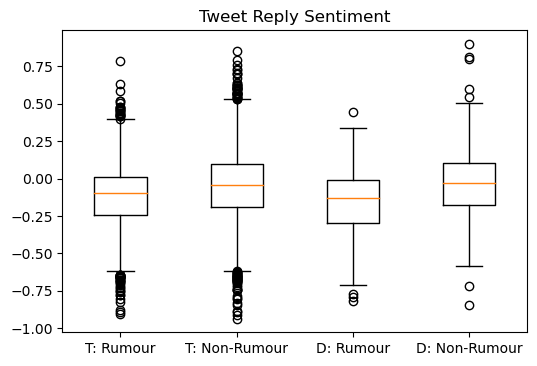

In [12]:

sent_data = a, b, c, d

sent_headers = ['T: Rumour', 'T: Non-Rumour', 'D: Rumour', 'D: Non-Rumour']
sent_title = 'Tweet Reply Sentiment'

box_plot(sent_data, sent_headers, sent_title)

## Correlation between number of replies and trustworthiness?

In [13]:
train_df[['label', 'responses']]

,label,responses
0,0,28
1,0,29
2,0,15
3,1,13
4,0,12
...,...,...
4636,1,18
4637,0,4
4638,1,0
4639,0,6


In [14]:
print(np.mean(train_df[train_df['label'] == 1]['responses'].values))
print(np.median(train_df[train_df['label'] == 1]['responses'].values))
print(np.mean(train_df[train_df['label'] == 0]['responses'].values))
print(np.median(train_df[train_df['label'] == 0]['responses'].values))

14.469993682880606
12.0
17.518966644865927
14.0


In [15]:
print(np.mean(dev_df[dev_df['label'] == 1]['responses'].values))
print(np.median(dev_df[dev_df['label'] == 1]['responses'].values))
print(np.mean(dev_df[dev_df['label'] == 0]['responses'].values))
print(np.median(dev_df[dev_df['label'] == 0]['responses'].values))

16.647058823529413
12.0
17.43765903307888
15.0
